# Lab 1 - XAI on Tabular Biomedical Data (SHAP, LIME, Counterfactuals)

In this lab you will explain a binary classifier for the Breast Cancer Wisconsin dataset. 

**Dataset:** Scikit-learn Breast Cancer Wisconsin (Diagnostic)

**Models:** Logistic Regression, Random Forest

**XAI Methods:** SHAP (global and local), LIME (local), simple counterfactuals with DiCE-ML

## Objectives
By the end of this lab you should be able to:
1. Train baseline models for a biomedical prediction task (malignant vs benign).
2. Generate global and local explanations with SHAP.
3. Compare SHAP with LIME on a few patients.
4. Produce counterfactual explanations (how to minimally change features to flip the decision) using DiCE-ML.

## 0) Environment Setup
This will install required libraries if missing. You can skip cells if your environment already has them.
- Run this once at the start. 

In [1]:
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("==")[0])
    except ImportError:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# pip_install("numpy")
# pip_install("pandas")
# pip_install("scikit-learn")
# pip_install("matplotlib")
# pip_install("shap")
# pip_install("lime")
# pip_install("dice-ml")


def plot_local_rf_waterfall(model, explainer, x_one_row_df, feature_names, desired_label=None):
    """
    Robust version: handles list/array outputs, multi-output, offset columns, etc.
    """
    # choose class to explain
    if desired_label is None:
        desired_label = int(model.predict(x_one_row_df)[0])

    classes = list(model.classes_)
    class_idx = classes.index(desired_label)

    # compute shap values
    sv = explainer.shap_values(x_one_row_df)
    ev = explainer.expected_value

    # pick correct shape depending on type
    if isinstance(sv, list):
        vals = np.array(sv[class_idx][0])
        base = ev[class_idx] if isinstance(ev, (list, np.ndarray)) else ev
    else:
        vals = np.array(sv[0])
        base = ev if not isinstance(ev, (list, np.ndarray)) else ev[class_idx]

    # remove extra offset or class columns if any
    if vals.ndim == 2:
        # sometimes it's (n_features, n_classes) — take column for our class
        vals = vals[:, class_idx]
    if vals.shape[0] != len(feature_names):
        vals = vals[:len(feature_names)]

    # create explanation object and plot
    exp = shap.Explanation(
        values=vals,
        base_values=float(np.ravel(base)[0]),
        data=x_one_row_df.values[0],
        feature_names=feature_names
    )
    shap.plots.waterfall(exp)

## 1) Load Data and Train/Test Split
We use the Breast Cancer Wisconsin (Diagnostic) dataset bundled with scikit-learn.
- Run the import cell, then inspect X.columns and X.describe() to understand scales, units, and possible outliers.
- Use the correlation heatmap and scatter/box plots to see which features separate benign vs malignant cases.

Q1: What does label 1 mean in this notebook? Is the dataset balanced enough for accuracy to be informative?

Q2: From the summary stats and plots, which 2-3 features show the clearest separation between classes? Which ones overlap heavily?

Q3: Which features are strongly correlated with each other? Note one risk this poses for modeling or explanations.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

data = load_breast_cancer(as_frame=True)
X = data.data
y = 1-data.target  # 1 = malignant, 0 = benign

feature_names = X.columns.tolist()
class_names = ["benign","malignant"]

In [3]:
X.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [4]:
X.describe().T #whole dataset

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [5]:
X[y==0].describe().T #class 0

,count,mean,std,min,25%,50%,75%,max
mean radius,357.0,12.146524,1.780512,6.981000,11.080000,12.200000,13.370000,17.85000
mean texture,357.0,17.914762,3.995125,9.710000,15.150000,17.390000,19.760000,33.81000
mean perimeter,357.0,78.075406,11.807438,43.790000,70.870000,78.180000,86.100000,114.60000
mean area,357.0,462.790196,134.287118,143.500000,378.200000,458.400000,551.100000,992.10000
mean smoothness,357.0,0.092478,0.013446,0.052630,0.083060,0.090760,0.100700,0.16340
mean compactness,357.0,0.080085,0.033750,0.019380,0.055620,0.075290,0.097550,0.22390
mean concavity,357.0,0.046058,0.043442,0.000000,0.020310,0.037090,0.059990,0.41080
mean concave points,357.0,0.025717,0.015909,0.000000,0.015020,0.023440,0.032510,0.08534
mean symmetry,357.0,0.174186,0.024807,0.106000,0.158000,0.171400,0.189000,0.27430
mean fractal dimension,357.0,0.062867,0.006747,0.051850,0.058530,0.061540,0.065760,0.09575


In [6]:
X[y==1].describe().T #class 1

,count,mean,std,min,25%,50%,75%,max
mean radius,212.0,17.462830,3.203971,10.950000,15.075000,17.325000,19.590000,28.11000
mean texture,212.0,21.604906,3.779470,10.380000,19.327500,21.460000,23.765000,39.28000
mean perimeter,212.0,115.365377,21.854653,71.900000,98.745000,114.200000,129.925000,188.50000
mean area,212.0,978.376415,367.937978,361.600000,705.300000,932.000000,1203.750000,2501.00000
mean smoothness,212.0,0.102898,0.012608,0.073710,0.094010,0.102200,0.110925,0.14470
mean compactness,212.0,0.145188,0.053987,0.046050,0.109600,0.132350,0.172400,0.34540
mean concavity,212.0,0.160775,0.075019,0.023980,0.109525,0.151350,0.203050,0.42680
mean concave points,212.0,0.087990,0.034374,0.020310,0.064620,0.086280,0.103175,0.20120
mean symmetry,212.0,0.192909,0.027638,0.130800,0.174050,0.189900,0.209850,0.30400
mean fractal dimension,212.0,0.062680,0.007573,0.049960,0.056598,0.061575,0.067075,0.09744


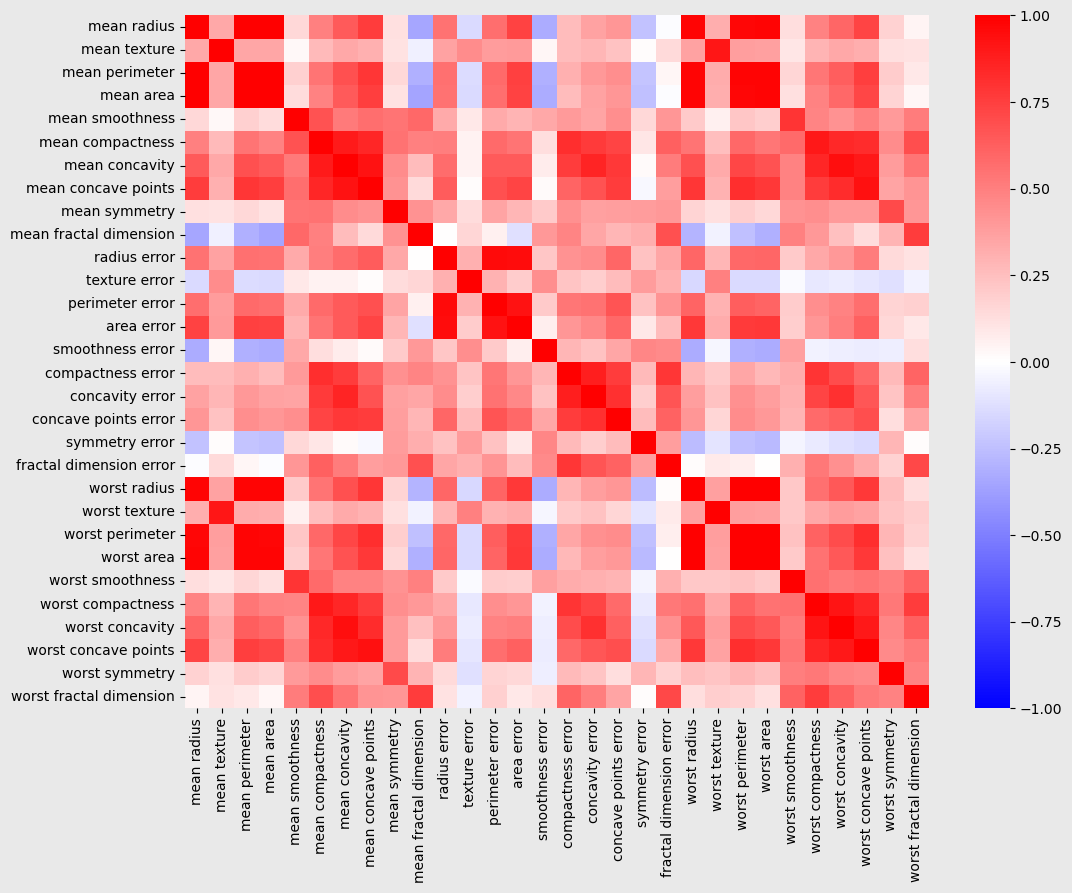

In [7]:
# compute the correlation matrix
corr = X.corr(method='spearman')

# plot the heatmap
fig=plt.figure(figsize=[12,9])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)

ax=sns.heatmap(corr, vmin=-1, vmax=1,cmap="bwr",
        xticklabels=X.columns,
        yticklabels=X.columns)

In [8]:
#Coeficients retrival between variables and target variable
coef_pearson=[]
coef_spearman=[]

labelp=[]
labels=[]

#color bars
colorp=[]
colors=[]
bleu="#9fb4ff"
rouge="#ffae9f"

#threshold for variables to be shpwn
threshold=0.35

for var in X.columns:
    cp=stats.pearsonr(y,X[var])[0]
    cs=stats.spearmanr(y,X[var])[0]
    #Pearson
    if abs(cp)>= threshold:
        coef_pearson.append(cp)
        labelp.append(var)
        if cp>0:
            colorp.append(bleu)
        else:
            colorp.append(rouge)
    #Spearman                       
    if abs(cs)>= threshold:
        coef_spearman.append(cs)
        labels.append(var)
        if cs>0:
            colors.append(bleu)
        else:
            colors.append(rouge)

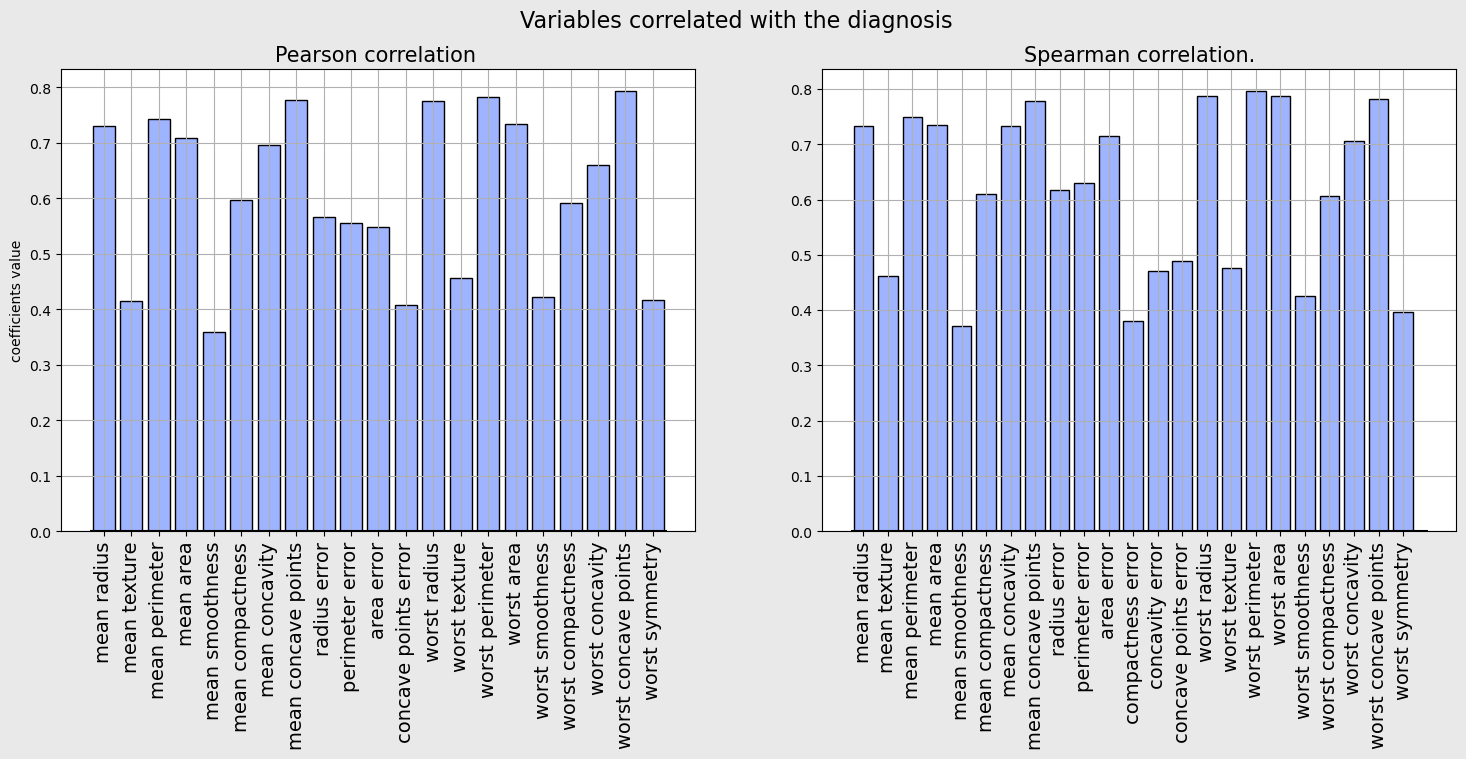

In [ ]:
fig=plt.figure(1,figsize=[18,6])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.suptitle("Variables correlated with the diagnosis",size=16)

# Pearson 
plt.subplot(1,2,1)
plt.title("Pearson correlation ",size=15)
plt.bar(np.arange(len(labelp))+1,coef_pearson,color=colorp,edgecolor='black')
plt.xticks(np.arange(len(labelp))+1,labelp,rotation=90,size=14)
plt.hlines(0,0.5,len(labelp)+0.5,color='black')
plt.ylabel("coefficients value")
# plt.ylim(-0.1,1)
plt.grid()

# Spearman 
plt.subplot(1,2,2)
plt.title("Spearman correlation",size=15)
plt.bar(np.arange(len(labels))+1,coef_spearman,color=colors,edgecolor='black')
plt.xticks(np.arange(len(labels))+1,labels,rotation=90, size=14)
plt.hlines(0,0.5,len(labels)+1,color='black')
# plt.ylim(-0.1,1)
plt.grid()

([<matplotlib.axis.XTick at 0x2217ab66d00>,
 [Text(0, 0, 'benign'), Text(1, 0, 'Malignant')])

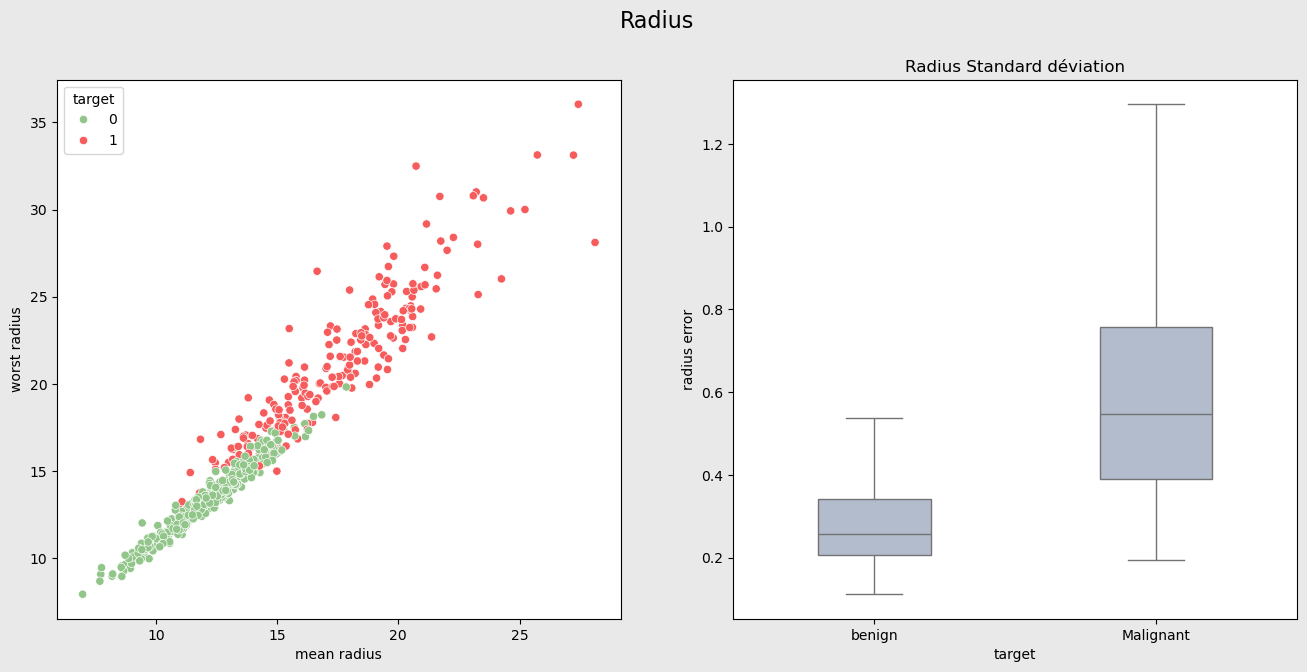

In [10]:
fig=plt.figure(1,figsize=(16,7))
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.suptitle("Radius",size=16)
plt.subplot(1,2,1)
sns.scatterplot(data=X,x="mean radius",y="worst radius",hue=y,palette=["#92c58a","#f65c5c"])
plt.subplot(1,2,2)
plt.title("Radius Standard déviation")
sns.boxplot(data=X,y="radius error",x=y,color="#afbbd0",width=0.4,showfliers=False)

plt.xticks([0,1],["benign","Malignant"])

([<matplotlib.axis.XTick at 0x2217bf9b700>,
 [Text(0, 0, 'benign'), Text(1, 0, 'Malignant')])

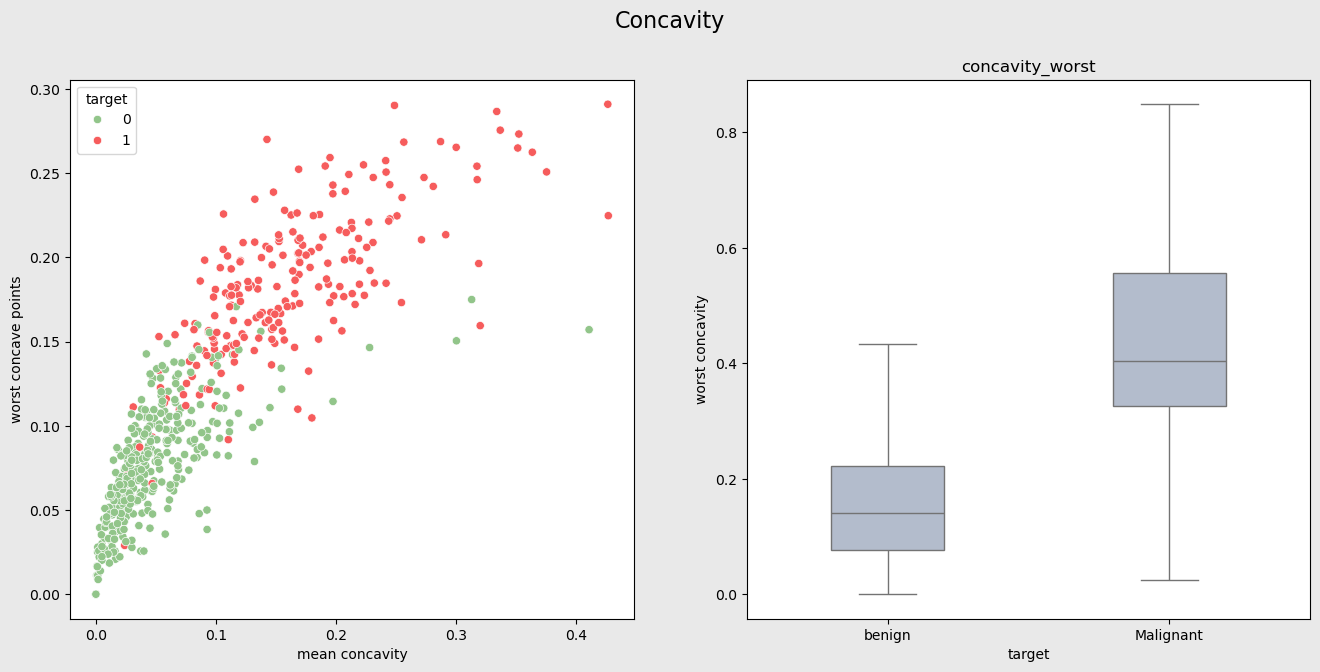

In [11]:
fig=plt.figure(1,figsize=[16,7])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.suptitle("Concavity",size=16)
plt.subplot(1,2,1)
sns.scatterplot(data=X,x="mean concavity",y='worst concave points',hue=y,palette=["#92c58a","#f65c5c"])
plt.subplot(1,2,2)
plt.title("concavity_worst")
sns.boxplot(data=X,y='worst concavity',x=y,color="#afbbd0",width=0.4,showfliers=False)
plt.xticks([0,1],["benign","Malignant"])

([<matplotlib.axis.XTick at 0x2217c0a9130>,
 [Text(0, 0, 'benign'), Text(1, 0, 'Malignant')])

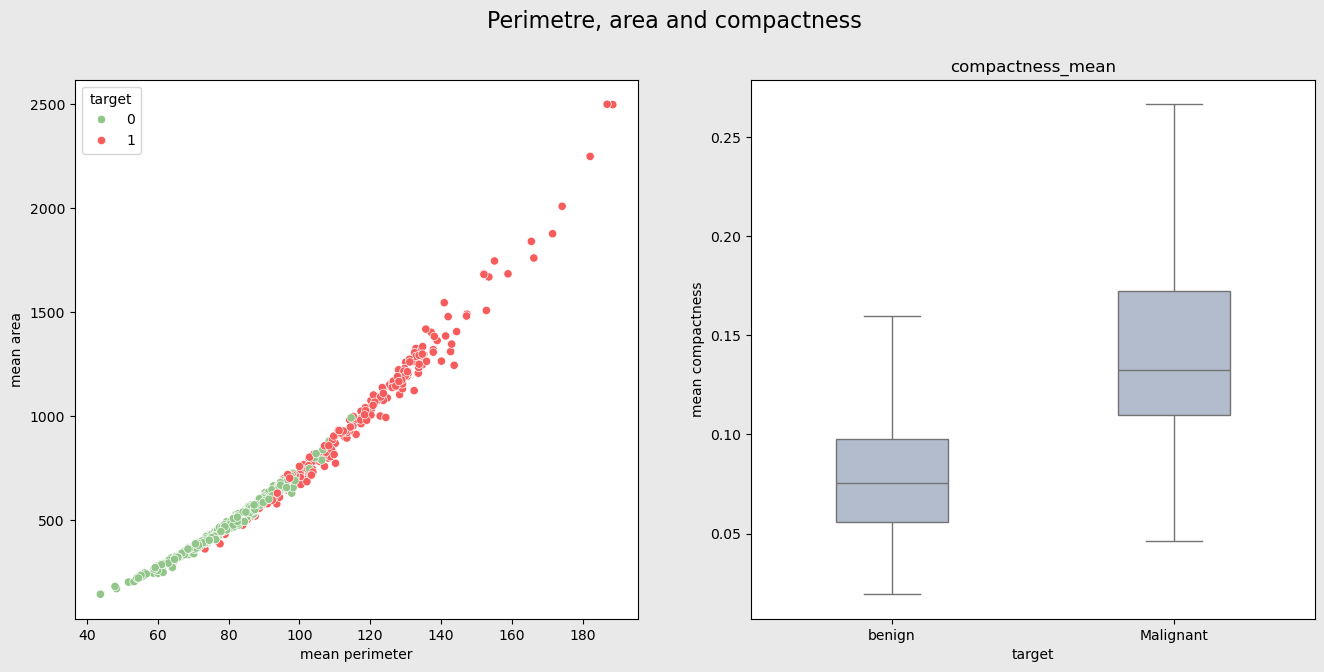

In [12]:
fig=plt.figure(1,figsize=[16,7])
fig.patch.set_facecolor('#E0E0E0')
fig.patch.set_alpha(0.7)
plt.suptitle("Perimetre, area and compactness",size=16)
plt.subplot(1,2,1)
sns.scatterplot(data=X,x='mean perimeter',y='mean area',hue=y,palette=["#92c58a","#f65c5c"])
plt.subplot(1,2,2)
plt.title("compactness_mean")
sns.boxplot(data=X,y='mean compactness',x=y,color="#afbbd0",width=0.4,showfliers=False)
plt.xticks([0,1],["benign","Malignant"])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## 2) Train Baseline Models
We train two types of models:
- Logistic Regression (intrinsically more interpretable) on scaled features.
- Random Forest (non-linear, harder to interpret directly) on raw features.

Q4: Why do we scale features for Logistic Regression but not for the Random Forest ?

Q5: Record accuracy and AUC for both models. Which would you prefer in a clinical workflow and why (e.g., discrimination, complexity, overfitting risk)?

In [58]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

logreg = LogisticRegression(max_iter=50, random_state=42)
logreg.fit(X_train_scaled_df, y_train)

rf = RandomForestClassifier(n_estimators=65, random_state=42)
rf.fit(X_train, y_train)  # RF is not scale-sensitive; we use raw features

y_pred_log = logreg.predict(X_test_scaled_df)
y_proba_log = logreg.predict_proba(X_test_scaled_df)[:,1]

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

In [59]:
from sklearn.metrics import confusion_matrix, recall_score

def sensitivity_specificity(y_true, y_pred):
    # Sensitivity = Recall for positive class (e.g. malignant = 1)
    sensitivity = recall_score(y_true, y_pred, pos_label=1)
    
    # Specificity = Recall for negative class (e.g. benign = 0)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    
    return sensitivity, specificity

# Logistic Regression
sens_log, spec_log = sensitivity_specificity(y_test, y_pred_log)

# Random Forest
sens_rf, spec_rf = sensitivity_specificity(y_test, y_pred_rf)

print("LogReg  - Acc:", accuracy_score(y_test, y_pred_log),
      "AUC:", roc_auc_score(y_test, y_proba_log),
      "Sensitivity:", sens_log,
      "Specificity:", spec_log)

print("RF      - Acc:", accuracy_score(y_test, y_pred_rf),
      "AUC:", roc_auc_score(y_test, y_proba_rf),
      "Sensitivity:", sens_rf,
      "Specificity:", spec_rf)

LogReg  - Acc: 0.9707602339181286 AUC: 0.997517523364486 Sensitivity: 0.9375 Specificity: 0.9906542056074766
RF      - Acc: 0.9766081871345029 AUC: 0.9965683411214953 Sensitivity: 0.9375 Specificity: 1.0


## 3) Global Explanations with SHAP
- For Random Forest we use TreeExplainer (fast, approximate).
- For Logistic Regression we use LinearExplainer on scaled data.
- The summary bar plot ranks features by average absolute contribution; the beeswarm plot shows direction (push toward benign vs malignant).

Q6: Compare the top 5 features from the RF and LR SHAP summaries. Which align with the earlier correlations and which differ? What might explain any differences?

In [60]:
import shap
import matplotlib.pyplot as plt

# Random Forest SHAP
bg = shap.sample(X_train, 200, random_state=42)  # background

explainer_rf = shap.TreeExplainer(
    rf,
    data=bg,
    model_output="probability",
    feature_perturbation="interventional"
)
shap_values_rf = explainer_rf.shap_values(X_test)

# shap_values_rf[1] corresponds to class 'benign' in scikit-learn's label ordering (0=malignant,1=benign)

# Logistic Regression SHAP (use linear explainer on scaled data)
explainer_lr = shap.LinearExplainer(logreg, X_train_scaled_df, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test_scaled_df)

c:\Users\ahalimi\AppData\Local\anaconda3\envs\PhD_GPU\lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


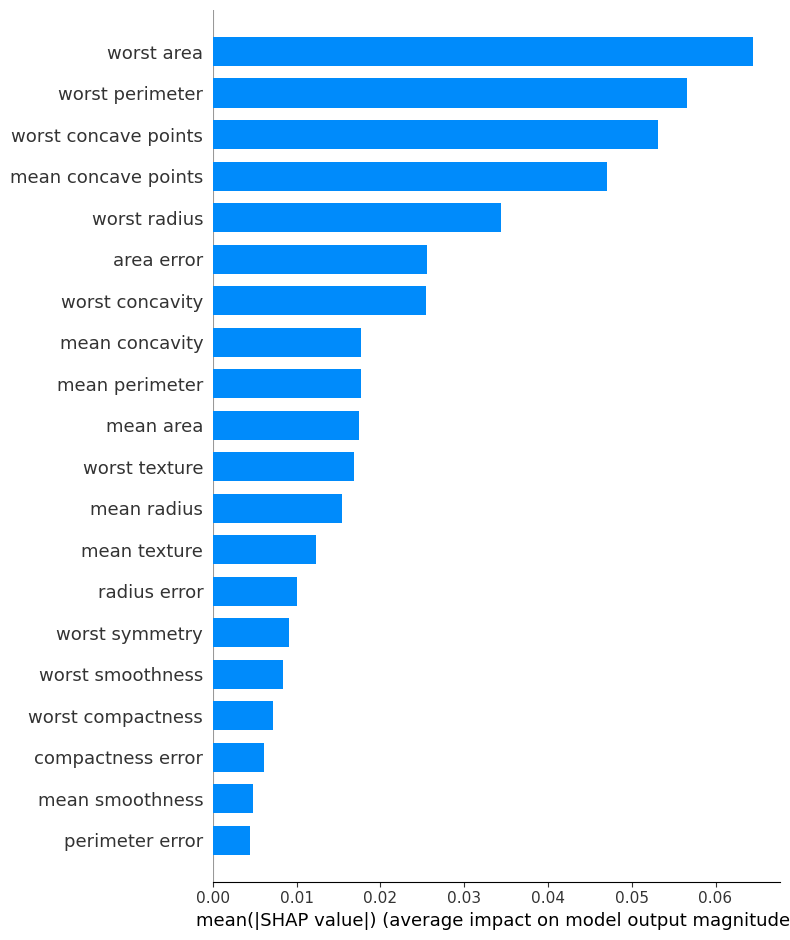

In [61]:
# Global bar plot (RF)
shap.summary_plot(shap_values_rf[:,:,1], X_test, feature_names=feature_names, plot_type="bar", show=True)

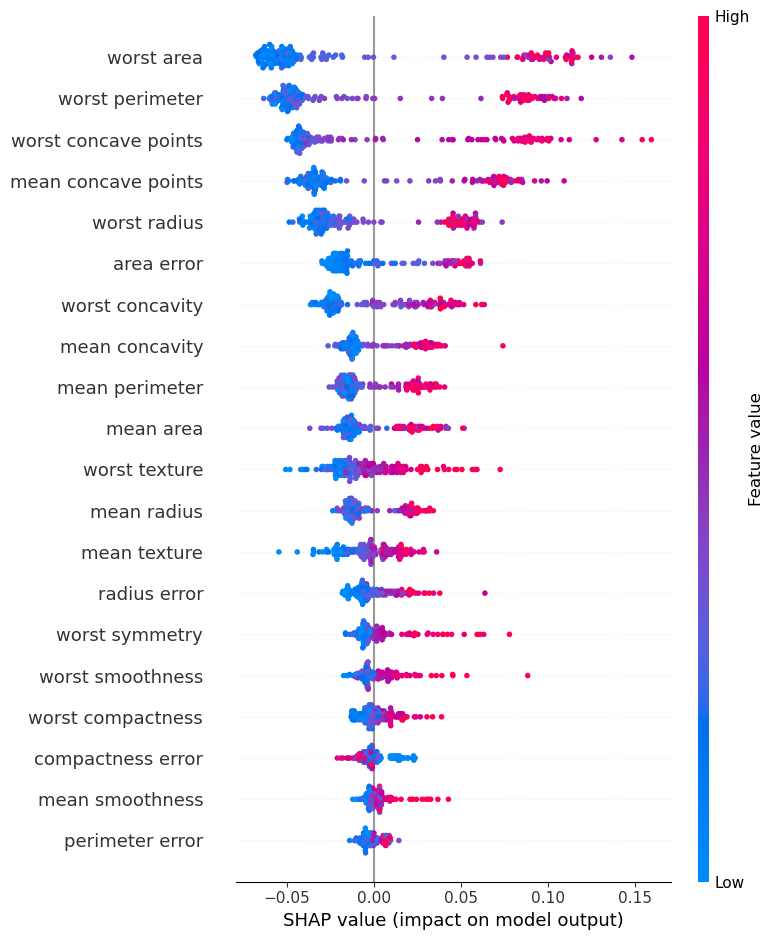

In [62]:
# Beeswarm plot (RF)
shap.summary_plot(shap_values_rf[:,:,1], X_test, feature_names=feature_names, show=True,max_display=20)

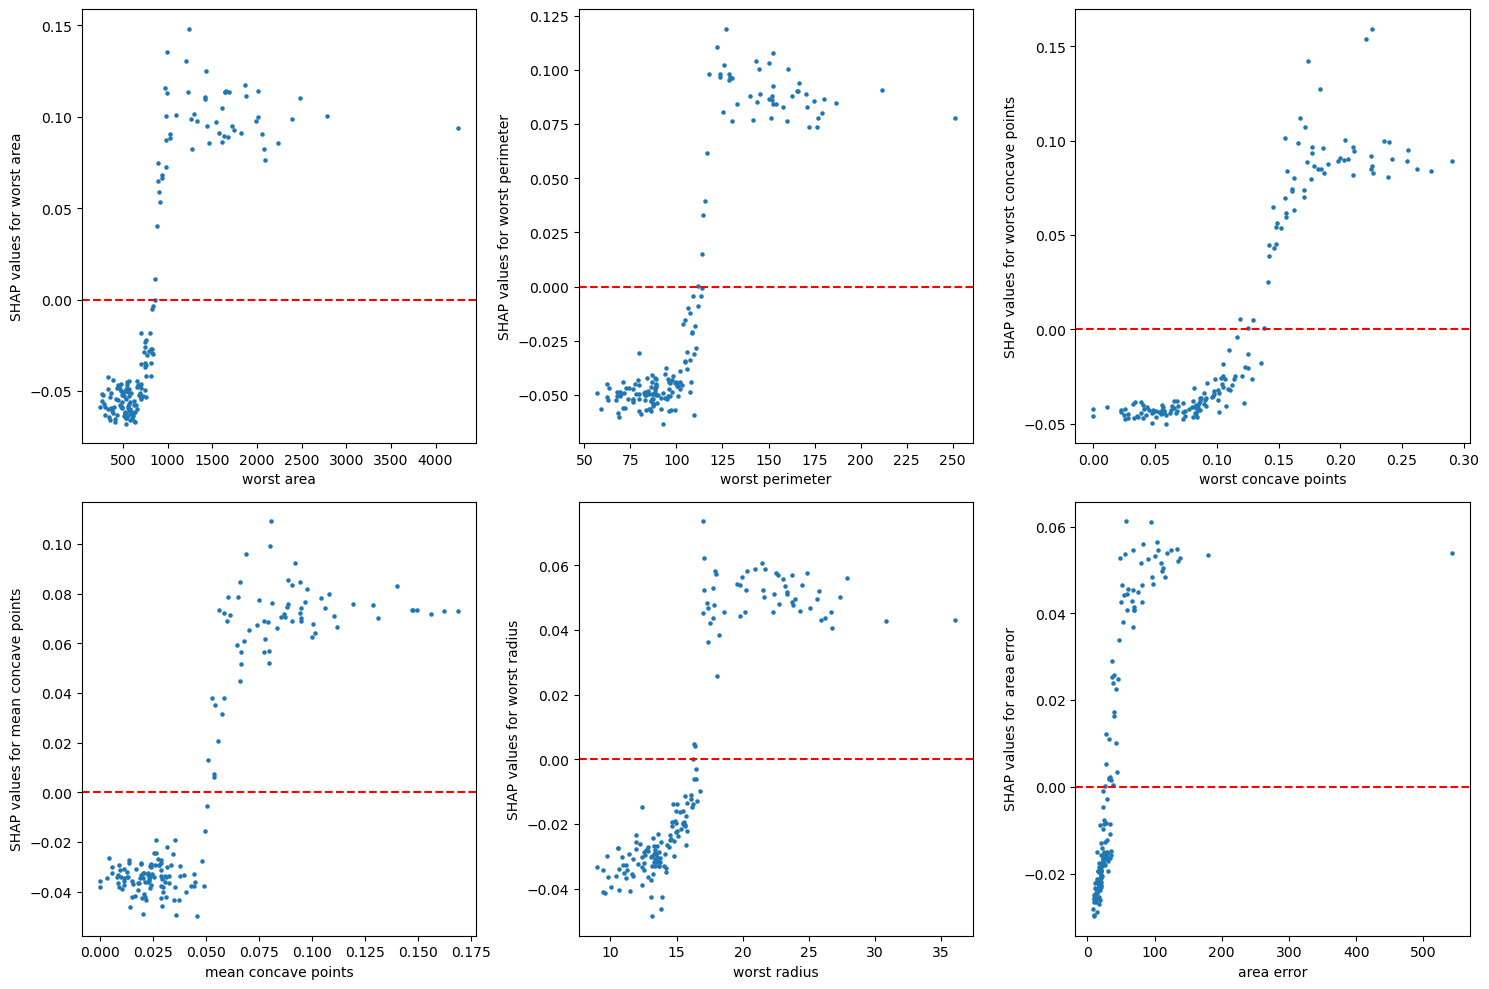

In [63]:
import matplotlib.pyplot as plt

shap_values_rf_dataframe= pd.DataFrame(shap_values_rf[:,:,1],columns=X_test.columns)
# Features to plot
features = pd.DataFrame(shap_values_rf[:,:,1],columns=X_test.columns).abs().sum().sort_values(ascending=False).keys()[:6]

# Create a subplot grid of 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figsize as needed

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Iterate over the features and their corresponding subplots
for i, feature in enumerate(features):
    # Plotting the scatter plot in the corresponding subplot
    axs[i].scatter(X_test[feature], shap_values_rf_dataframe[feature], s=5,alpha=1)

    # Adding x and y labels
    axs[i].set_xlabel(f"{feature}")
    axs[i].set_ylabel(f"SHAP values for {feature}")

    # Adding a horizontal line
    axs[i].axhline(0, color='red', linestyle='--')

    # Adding vertical lines and their text annotations
    # for vline_pos in vline_positions[feature]:
    #     axs[i].axvline(x=vline_pos, color='red')
    #     axs[i].text(vline_pos, axs[i].get_ylim()[1]-0.05, f' {vline_pos}', verticalalignment='top', color='red')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

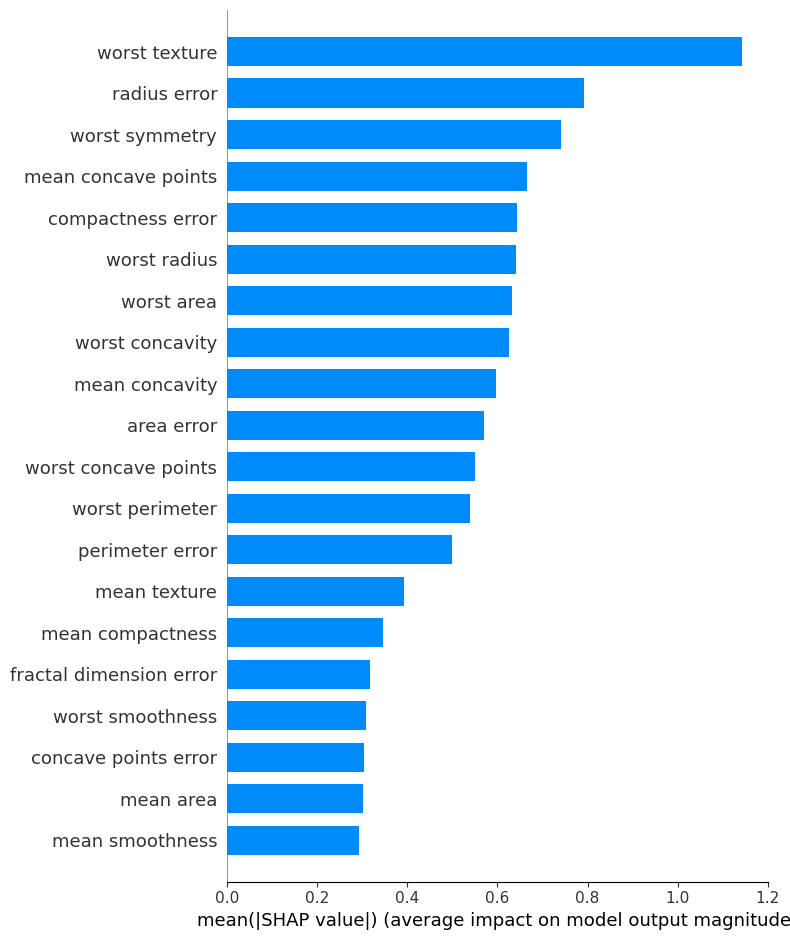

In [64]:
# Global bar plot (LogReg)
shap.summary_plot(shap_values_lr, X_test_scaled_df, feature_names=feature_names, plot_type="bar", show=True)


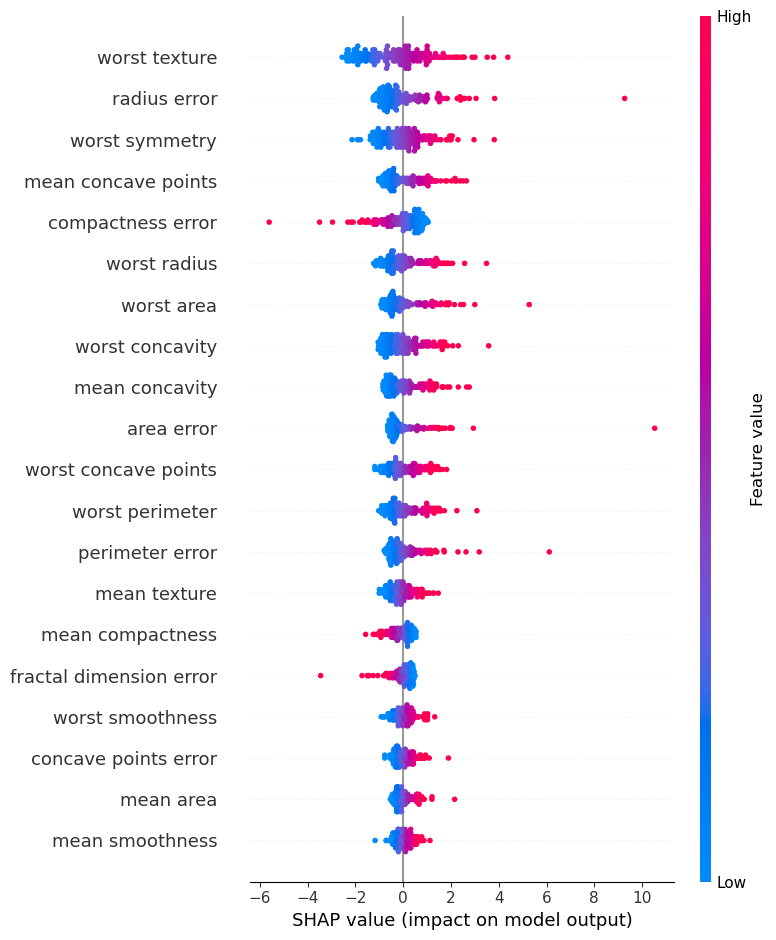

In [65]:
# Beeswarm plot (LogReg)
shap.summary_plot(shap_values_lr, X_test_scaled_df, feature_names=feature_names, show=True)

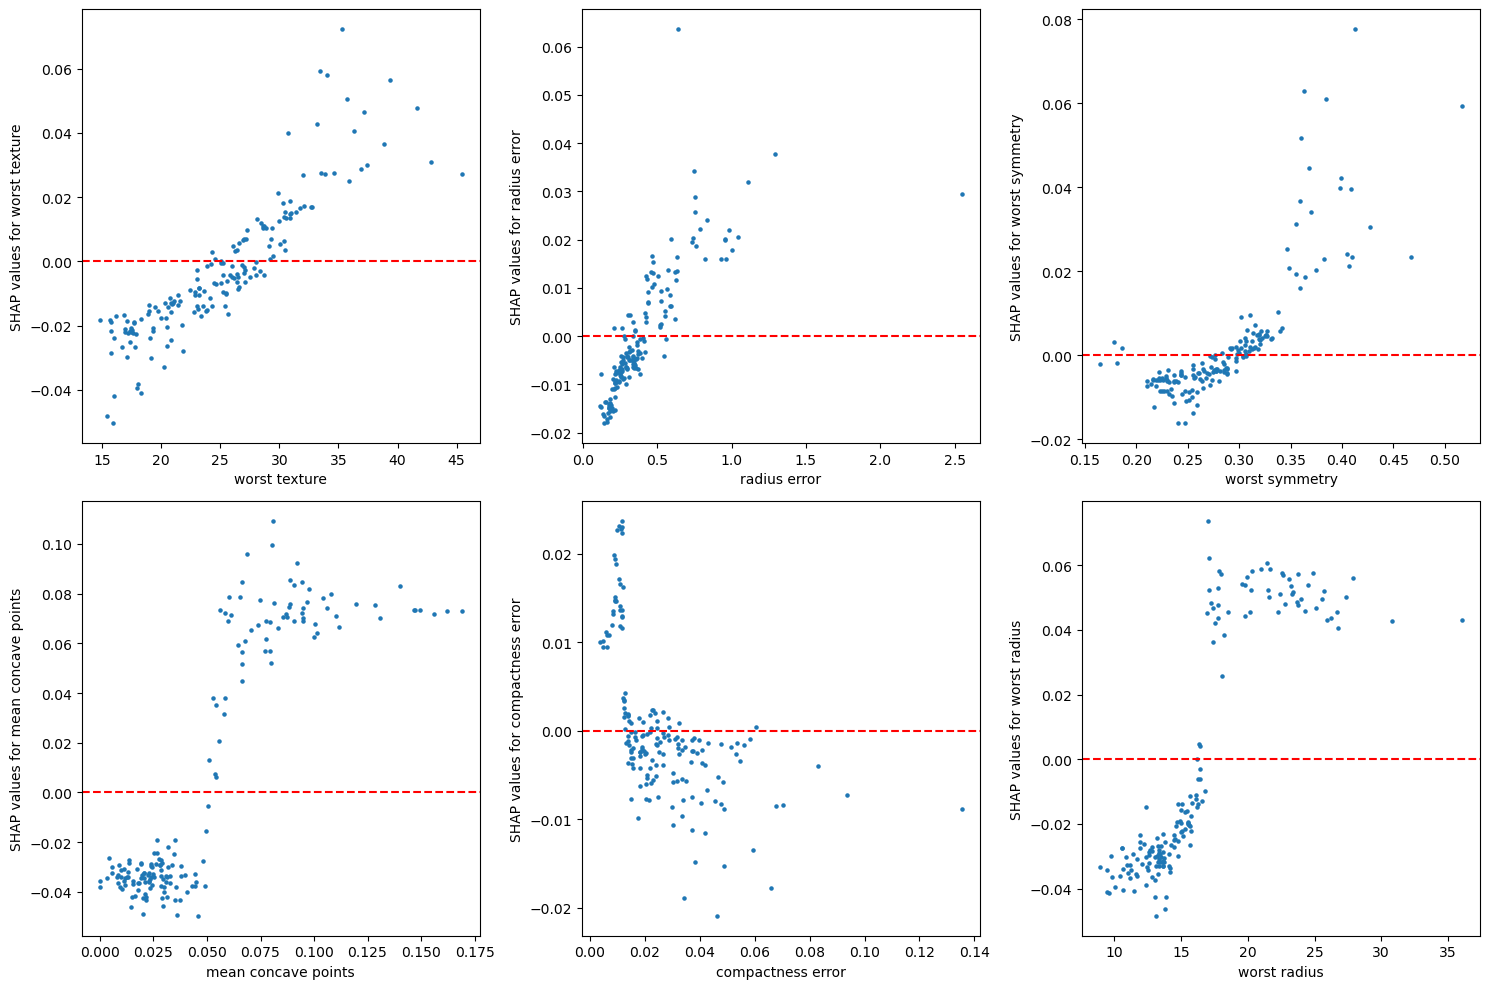

In [66]:
import matplotlib.pyplot as plt

shap_values_lr_dataframe= pd.DataFrame(shap_values_lr,columns=X_test.columns)
# Features to plot
features = pd.DataFrame(shap_values_lr,columns=X_test.columns).abs().sum().sort_values(ascending=False).keys()[:6]

# Create a subplot grid of 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figsize as needed

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Iterate over the features and their corresponding subplots
for i, feature in enumerate(features):
    # Plotting the scatter plot in the corresponding subplot
    axs[i].scatter(X_test[feature], shap_values_rf_dataframe[feature], s=5,alpha=1)

    # Adding x and y labels
    axs[i].set_xlabel(f"{feature}")
    axs[i].set_ylabel(f"SHAP values for {feature}")

    # Adding a horizontal line
    axs[i].axhline(0, color='red', linestyle='--')

    # Adding vertical lines and their text annotations
    # for vline_pos in vline_positions[feature]:
    #     axs[i].axvline(x=vline_pos, color='red')
    #     axs[i].text(vline_pos, axs[i].get_ylim()[1]-0.05, f' {vline_pos}', verticalalignment='top', color='red')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

## 4) Local Explanations: SHAP Force Plots + LIME
Pick a few test patients and compare local explanations. 
- Inspect the true label and model probabilities for the chosen patient.
- Use the SHAP waterfall plot with RF to see how features push the prediction.
- Run LIME on the same patient and compare the top contributing features.

Q7: For each patient, list the top 3 contributing features from SHAP and from LIME. Do the signs and magnitudes agree? If not, suggest a reason (model differences, feature correlations, sampling noise). How stable are the explanations when you change the patient index?

In [67]:
# Pick an index from the test set
idx = X_test.index[:1][0]
x_instance_raw = X_test.loc[idx:idx]
x_instance_scaled = X_test_scaled_df.loc[idx:idx]

print("True label:", class_names[y_test.loc[idx]])
print(f"RF proba:", float(rf.predict_proba(x_instance_raw)[:,1]))

True label: benign
RF proba: 0.07692307692307693


C:\Users\ahalimi\AppData\Local\Temp\ipykernel_65796\1544912282.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"RF proba:", float(rf.predict_proba(x_instance_raw)[:,1]))


True label: benign
LogReg proba: 0.010082523230118521
RF proba: 0.015384615384615385


C:\Users\ahalimi\AppData\Local\Temp\ipykernel_65796\2958869433.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("LogReg proba:", float(logreg.predict_proba(x_instance_scaled)[:,1]))
C:\Users\ahalimi\AppData\Local\Temp\ipykernel_65796\2958869433.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("RF proba:", float(rf.predict_proba(x_instance_raw)[:,1]))


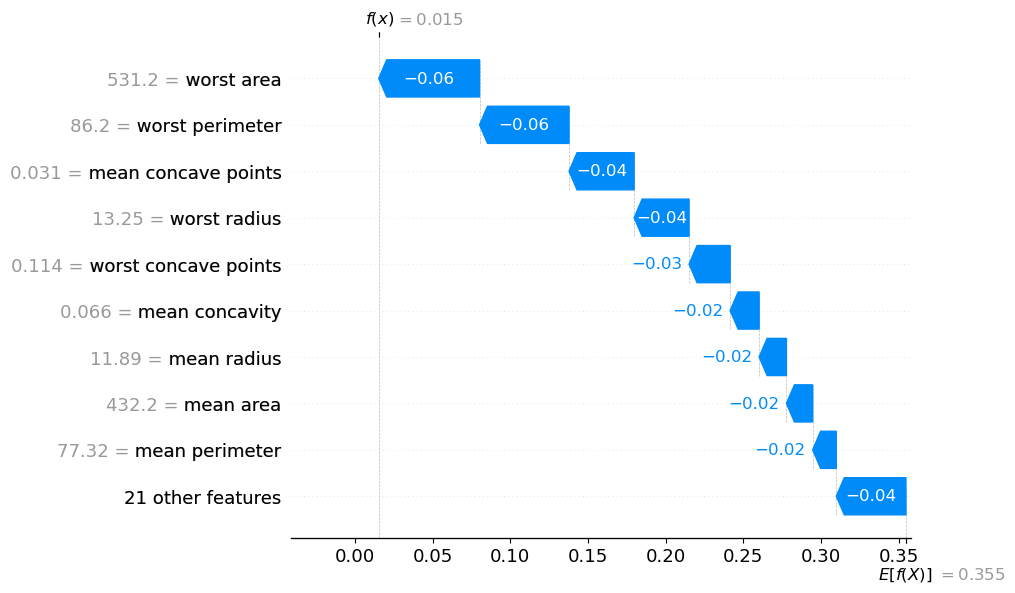

In [68]:
indx=10
# Pick an index from the test set
idx = X_test.index[indx]
x_instance_raw = X_test.loc[idx:idx]
x_instance_scaled = X_test_scaled_df.loc[idx:idx]

print("True label:", class_names[y_test.loc[idx]])
print("LogReg proba:", float(logreg.predict_proba(x_instance_scaled)[:,1]))
print("RF proba:", float(rf.predict_proba(x_instance_raw)[:,1]))

feature_names = list(X_test.columns)
plot_local_rf_waterfall(rf, explainer_rf, x_instance_raw, feature_names, desired_label=1)

In [69]:
# LIME local explanation
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    mode='classification'
)

exp = lime_explainer.explain_instance(
    data_row=np.array(x_instance_raw)[0],
    predict_fn=rf.predict_proba,
    num_features=10
)
exp.as_list()


c:\Users\ahalimi\AppData\Local\anaconda3\envs\PhD_GPU\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[('513.92 < worst area <= 684.55', -0.062344149864273495),
 ('0.02 < mean concave points <= 0.03', -0.049295067410645266),
 ('83.92 < worst perimeter <= 97.73', -0.04551759874519726),
 ('worst symmetry > 0.32', 0.043913771087945405),
 ('12.98 < worst radius <= 14.98', -0.042385519550595344),
 ('17.77 < area error <= 24.61', -0.04056102581430417),
 ('416.45 < mean area <= 548.75', -0.01990125604473088),
 ('0.23 < radius error <= 0.32', -0.018086635835183506),
 ('compactness error > 0.03', -0.013899103568461699),
 ('75.01 < mean perimeter <= 86.36', -0.013143513832676285)]

## 5) Counterfactual Explanations with DiCE-ML
We generate several actionable counterfactuals for a Logistic Regression model.
- Identify an instance predicted as malignant, then generate opposite-class counterfactuals.
- Focus on whether suggested feature changes are realistic.

Q8: Are the proposed changes clinically plausible and actionable? Which features would you mark as immutable or high-cost, and how would that change the usefulness of these counterfactuals?

In [72]:
import dice_ml
from dice_ml import Dice
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Build a simple sklearn-compatible pipeline for DiCE
# (here: only scaling, already applied outside, but we wrap to be explicit)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=100, random_state=42))])
pipeline.fit(X_train, y_train)

# DiCE Data and Model wrappers
dice_data = dice_ml.Data(dataframe=pd.concat([X_train, y_train], axis=1), continuous_features=feature_names, outcome_name='target' if 'target' in pd.concat([X_train, y_train], axis=1).columns else y_train.name)
# Ensure the outcome column is named correctly
if dice_data.outcome_name != 'target':
    df = pd.concat([X_train.copy(), y_train.copy()], axis=1)
    df.columns = feature_names + ['target']
    dice_data = dice_ml.Data(dataframe=df, continuous_features=feature_names, outcome_name='target')

dice_model = dice_ml.Model(model=pipeline, backend="sklearn")

exp_gen = Dice(dice_data, dice_model, method="random")

# Choose one instance predicted as malignant (class 1) to try flipping

test_df = X_test.copy()
test_df['target'] = y_test.values
x_cf = test_df[test_df['target']==1].drop(columns=['target']).iloc[[1]]
# if x_cf.shape[0]==0:
#     x_cf = test_df.drop(columns=['target']).head(1)

query_instance = x_cf.iloc[0:1]

dice_exp = exp_gen.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_class="opposite"
)
# shows a styled table in the notebook
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

Query instance (original outcome : 1)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,16.25,19.51,109.800003,815.799988,0.1026,0.1893,0.2236,0.09194,0.2151,0.06578,...,23.049999,122.099998,939.700012,0.1377,0.4462,0.5897,0.1775,0.3318,0.09136,1



Diverse Counterfactual set (new outcome: 0)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,0.0939,-,-,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,...,-,81.55,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,0.7367,0.1,-,-,-,0.0


In [73]:
# keeps only features that differ in at least one counterfactual; constant columns across CFEs are dropped completely.

# Original instance (1 row → Series)
orig = dice_exp.cf_examples_list[0].test_instance_df.iloc[0]

# All counterfactuals as DataFrame
cfs = dice_exp.cf_examples_list[0].final_cfs_df.copy()

# Keep only common feature columns (no target, no extra cols)
common_cols = orig.index.intersection(cfs.columns)
cfs = cfs[common_cols]
orig = orig[common_cols]

# Separate numeric and non-numeric columns
num_cols = cfs.select_dtypes(include="number").columns
cat_cols = cfs.columns.difference(num_cols)

# Create mask of equal-to-original (with tolerance for numeric)
mask_equal = pd.DataFrame(False, index=cfs.index, columns=cfs.columns)

# Numeric: use np.isclose
mask_equal[num_cols] = np.isclose(
    cfs[num_cols],
    orig[num_cols],
    rtol=1e-6,
    atol=1e-6,
)

# Non-numeric: exact equality
mask_equal[cat_cols] = cfs[cat_cols].eq(orig[cat_cols])

# Build changes table: keep CF values where different, put "–" where same as original
df_changes = cfs.where(~mask_equal, other="–")

# Columns that vary across CFs (at least 2 distinct values)
cols_vary_across_cfs = cfs.nunique() > 1

df_cf_varying = cfs.loc[:, cols_vary_across_cfs]
print("CFs: only features that differ")
display(df_cf_varying)
print('Original sample')
display(x_cf[df_cf_varying.columns])

CFs: only features that differ


,texture error,compactness error,worst perimeter,worst smoothness,worst compactness,worst concavity
0,4.7800,0.05470,122.10,0.0939,0.4462,0.5897
1,0.9857,0.09303,81.55,0.1377,0.4462,0.5897
2,0.9857,0.05470,122.10,0.1377,0.7367,0.1000


Original sample


,texture error,compactness error,worst perimeter,worst smoothness,worst compactness,worst concavity
479,0.9857,0.0547,122.1,0.1377,0.4462,0.5897


## Wrap-up and Reflection
- Q9: Why is it easier for DiCE to find realistic counterfactuals when moving from benign → malignant, but harder when moving malignant → benign? Consider the shape of the data distribution and the decision boundary.

- Q10: Why might unconstrained counterfactual explanations suggest biologically impossible changes when attempting to flip a malignant prediction to benign, and how can adding domain constraints improve realism?

- Q11: In 4-5 sentences, discuss faithfulness, stability, and clinical plausibility across SHAP, LIME, and DiCE. Which explanation type would you trust to present to clinicians and why?
- Optional: rerun LIME/SHAP with a different random seed or number of features and note how the explanations move.